# Simplificação de rede viária com neatnet

### Autor: Ana Luisa Maffini
### Contato: analuisamaffini@gmail.com
### Data: 17/11/2025

Referência: Fleischmann, M., Vybornova, A., & Gaboardi, J.D. (2025). uscuni/neatnet. Zenodo. https://doi.org/10.5281/zenodo.14765801

Este notebook lê uma rede de segmentos (vias), aplica `neatnet.neatify` para simplificar a geometria,
e salva o resultado em um novo arquivo (GeoPackage/GeoParquet).

Use este notebook no VS Code, escolhendo um ambiente Python onde você instalou `geopandas`, `pyogrio`, `shapely` e `neatnet`.

In [1]:
# 1. Instalação das dependências (se necessário)
# Rode esta célula apenas se ainda não tiver os pacotes instalados neste ambiente.

%pip install geopandas pyogrio shapely neatnet


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 2. Imports principais

import pathlib

import geopandas as gpd
import neatnet
import matplotlib.pyplot as plt

%matplotlib inline


C:\Users\analu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 3. Configuração de caminhos
# Ajuste estes caminhos conforme a sua organização de dados.

DATA_DIR = pathlib.Path(r"C:\Users\analu\OneDrive\Desktop")  # altere para a pasta dos seus dados

# Arquivo de entrada: rede viária (GeoPackage, Shapefile, GeoJSON etc.)
IN_FILE = DATA_DIR / "sm.gpkg"  # pode ser .shp, .geojson, etc.

# Se IN_FILE for um GeoPackage com várias camadas, informe o nome da camada;
# se for Shapefile (.shp), pode deixar como None.
LAYER_NAME = "osm_segments_4316907"  # ajuste se necessário; use None se não for GPKG com múltiplas camadas

# Arquivo de saída: rede simplificada (GeoPackage)
OUT_FILE = DATA_DIR / "rede_segmentos_simplificada_neatnet.gpkg"

print("Pasta de dados:", DATA_DIR)
print("Arquivo de entrada:", IN_FILE)
print("Arquivo de saída:", OUT_FILE)


Pasta de dados: C:\Users\analu\OneDrive\Desktop
Arquivo de entrada: C:\Users\analu\OneDrive\Desktop\sm.gpkg
Arquivo de saída: C:\Users\analu\OneDrive\Desktop\rede_segmentos_simplificada_neatnet.gpkg


In [4]:
# 4. Leitura da rede de segmentos com GeoPandas

if not IN_FILE.exists():
    raise FileNotFoundError(f"Arquivo de entrada não encontrado: {IN_FILE}")

if IN_FILE.suffix.lower() == ".gpkg" and LAYER_NAME is not None:
    streets = gpd.read_file(IN_FILE, layer=LAYER_NAME)
else:
    streets = gpd.read_file(IN_FILE)

print("Número de segmentos lidos:", len(streets))
streets.head()


Número de segmentos lidos: 18054


,u,v,key,osmid,highway,lanes,maxspeed,oneway,ref,reversed,length,name,bridge,junction,access,area,tunnel,geometry
0,353776099,5468190526,0,568366603,trunk,2,50,True,RSC-287,False,16.996707,None,None,None,None,None,None,"LINESTRING (238119.639 6710872.313, 238135.031..."
1,353776099,1935586298,0,568367110,tertiary,None,None,True,None,False,32.256332,Avenida Rubem Martin Berta,None,None,None,None,None,"LINESTRING (238119.639 6710872.313, 238143.118..."
2,5468190526,5468190522,0,986897886,trunk,2,50,True,RSC-287,False,67.840096,None,None,None,None,None,None,"LINESTRING (238135.031 6710879.584, 238198.833..."
3,5468190526,1789869573,0,269113624,trunk_link,2,None,True,None,False,42.972462,None,None,None,None,None,None,"LINESTRING (238135.031 6710879.584, 238137.005..."
4,1935586298,5468190524,0,568367109,tertiary,None,None,True,None,False,19.307589,Avenida Rubem Martin Berta,None,None,None,None,None,"LINESTRING (238143.118 6710850.201, 238136.765..."


In [5]:
# 5. Conferir e, se necessário, reprojetar o CRS

print("CRS original:", streets.crs)

if streets.crs is None:
    raise ValueError("A camada não tem CRS definido. Defina o CRS original antes de reprojetar.")

# Se o CRS for geográfico (graus), reprojete para um CRS projetado em metros
# Exemplos (Brasil):
#  - EPSG:31982 -> SIRGAS 2000 / UTM zone 22S
#  - EPSG:31983 -> SIRGAS 2000 / UTM zone 23S

TARGET_CRS = "EPSG:31982"  # ajuste conforme sua área de estudo

if streets.crs.is_geographic:
    print("Reprojetando de", streets.crs, "para", TARGET_CRS)
    streets = streets.to_crs(TARGET_CRS)

print("CRS em uso:", streets.crs)


CRS original: None


ValueError: A camada não tem CRS definido. Defina o CRS original antes de reprojetar.

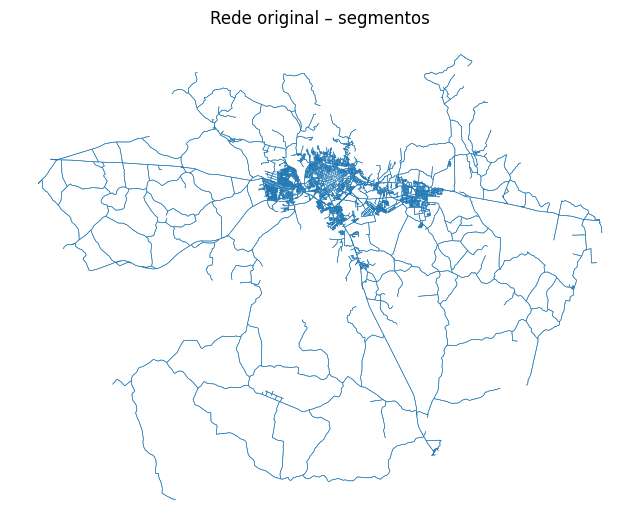

In [6]:
# 6. Visualização rápida da rede original (opcional)

ax = streets.plot(figsize=(8, 8), linewidth=0.4)
ax.set_title("Rede original – segmentos")
ax.set_axis_off()
plt.show()


In [7]:
# 7. Aplicar neatnet.neatify à rede

simplified = neatnet.neatify(streets)
print("Número de segmentos simplificados:", len(simplified))
simplified.head()


C:\Users\analu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\neatnet\simplify.py:864: UserWarning: The input `streets` data does not have an assigned coordinate reference system. Assuming a projected CRS in meters.
  _check_input_crs(streets, exclusion_mask)
C:\Users\analu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\neatnet\simplify.py:590: UserWarning: Could not create a connection as it would lead outside of the artifact.
  nx_gx_cluster(


Número de segmentos simplificados: 8014


,geometry,_status,u,v,key,osmid,highway,lanes,maxspeed,oneway,ref,reversed,length,name,bridge,junction,access,area,tunnel
0,"LINESTRING (227524.45 6709683.99, 227585.991 6...",new,NaN,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None
1,"LINESTRING (227583.786 6709479.399, 227624.791...",changed,1.784261e+09,1.784261e+09,0.0,167025852,residential,None,None,False,None,True,177.537694,Rua Ernesto Lazzaron,None,None,None,None,None
2,"LINESTRING (227770.145 6709434.851, 227806.971...",new,NaN,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None
3,"LINESTRING (228056.827 6709692.236, 228057.588...",changed,7.675082e+09,6.391175e+08,0.0,958914456,trunk_link,2,40,True,BR-158;BR-287;BR-392,False,15.282471,None,None,None,None,None,None
4,"LINESTRING (228641.206 6709900.391, 228312.614...",changed,2.144062e+09,2.144062e+09,0.0,204398620,residential,2,None,False,None,True,69.615546,Rua Dom Luiz Victor Sartori,None,None,None,None,None


C:\Users\analu\AppData\Local\Temp\ipykernel_13184\424167897.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centro = streets.unary_union.centroid


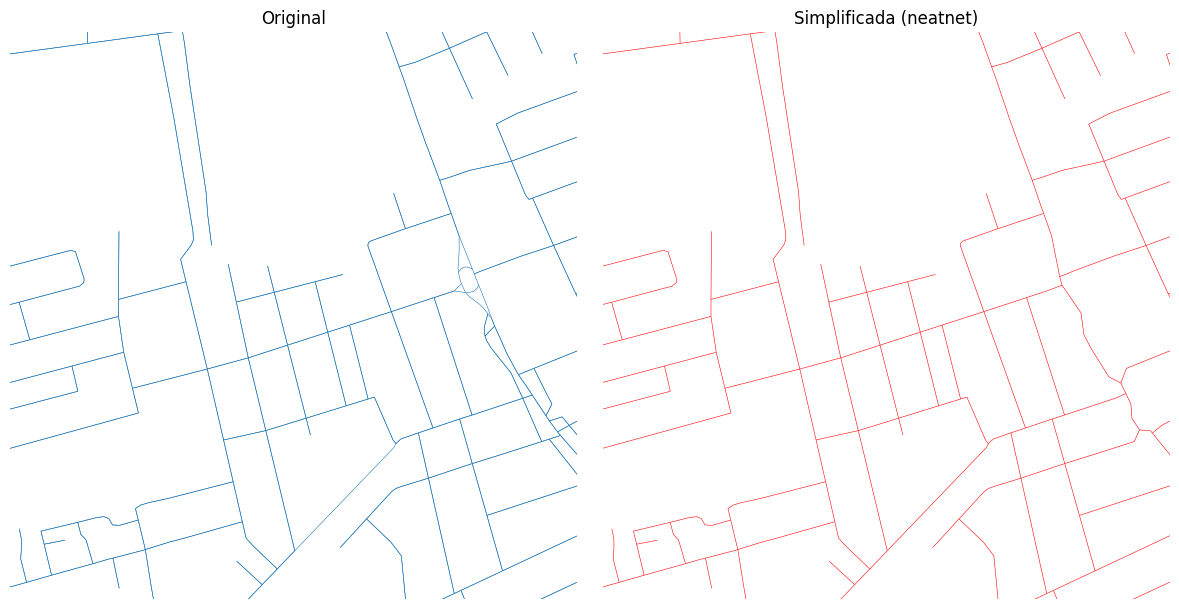

In [8]:
# 8. Comparar original vs simplificada (zoom em uma área de interesse)

centro = streets.unary_union.centroid
dx = 500  # metros (ajuste conforme a escala da sua cidade)
dy = 500

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

streets.plot(ax=axs[0], linewidth=0.4)
axs[0].set_title("Original")
axs[0].set_axis_off()

simplified.plot(ax=axs[1], linewidth=0.4, color="red")
axs[1].set_title("Simplificada (neatnet)")
axs[1].set_axis_off()

for ax in axs:
    ax.set_xlim(centro.x - dx, centro.x + dx)
    ax.set_ylim(centro.y - dy, centro.y + dy)

plt.tight_layout()
plt.show()


In [9]:
# 9. Salvar a rede simplificada em GeoPackage

OUT_LAYER = "segmentos_simplificados"  # nome da camada dentro do GPKG

simplified.to_file(OUT_FILE, layer=OUT_LAYER, driver="GPKG")
print("GeoPackage salvo em:", OUT_FILE)


GeoPackage salvo em: C:\Users\analu\OneDrive\Desktop\rede_segmentos_simplificada_neatnet.gpkg


C:\Users\analu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [ ]:
# 10. (Opcional) Salvar também em GeoParquet

OUT_PARQUET = DATA_DIR / "rede_segmentos_simplificada_neatnet.parquet"
simplified.to_parquet(OUT_PARQUET)
print("GeoParquet salvo em:", OUT_PARQUET)
